In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import os
import warnings
warnings.filterwarnings('ignore')

# Configuration - you can modify these values
DATA_FILE = 'data/2021_xrsa_xrsb.csv'
START_TIME = 361      # Start time in minutes
END_TIME = 720        # End time in minutes
MIN_GAUSSIANS = 10    # Minimum Gaussian components
MAX_GAUSSIANS = 20    # Maximum Gaussian components

print("🔧 Configuration:")
print(f"   Data file: {DATA_FILE}")
print(f"   Time range: {START_TIME}-{END_TIME} minutes")
print(f"   Gaussian range: {MIN_GAUSSIANS}-{MAX_GAUSSIANS}")
print(f"   Duration: {(END_TIME - START_TIME)/60:.1f} hours")

🔧 Configuration:
   Data file: data/2021_xrsa_xrsb.csv
   Time range: 361-720 minutes
   Gaussian range: 10-20
   Duration: 6.0 hours


In [28]:
def check_dependencies():
    """Check if required packages are available"""
    try:
        from pybaselines import Baseline
        print("✅ pybaselines available - using advanced baseline correction")
        return True
    except ImportError:
        print("⚠️  pybaselines not available - using simple detrending")
        return False

def load_data(file_path):
    """Load and validate data with proper error handling"""
    try:
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Data file not found: {file_path}")
        
        data = pd.read_csv(file_path)
        
        if data.empty:
            raise ValueError("Data file is empty")
        
        required_columns = ['time_minutes', 'xrsa_flux_observed', 'xrsb_flux_observed']
        missing_columns = [col for col in required_columns if col not in data.columns]
        
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")
        
        # Check for NaN values
        nan_counts = data[required_columns].isnull().sum()
        if nan_counts.any():
            print(f"⚠️  Found NaN values: {nan_counts.to_dict()}")
            data = data.dropna(subset=required_columns)
            print(f"✅ Cleaned data shape: {data.shape}")
        
        return data
        
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None

#### Baseline Correction | Graphical User Interface

In [29]:
# p -> asymmetry parameter; lam -> regularization parameter;
def apply_baseline_correction(time_data, xrsa_data, xrsb_data, use_pybaselines=True):
    """Apply baseline correction with fallback option"""
    if use_pybaselines:
        try:
            from pybaselines import Baseline
            baseline_fitter = Baseline()
            
            # XRSA baseline correction
            xrsa_baseline, _ = baseline_fitter.asls(xrsa_data, lam=1e12, p=0.005)
            xrsa_corrected = xrsa_data - xrsa_baseline
            
            # XRSB baseline correction
            xrsb_baseline, _ = baseline_fitter.asls(xrsb_data, lam=1e12, p=0.005)
            xrsb_corrected = xrsb_data - xrsb_baseline
            
            print("✅ Baseline correction completed using pybaselines AsLS method")
            return xrsa_baseline, xrsa_corrected, xrsb_baseline, xrsb_corrected
            
        except Exception as e:
            print(f"⚠️  pybaselines failed: {e}, using fallback method")
            use_pybaselines = False
    
    if not use_pybaselines:
        # Fallback to simple linear detrending
        from scipy import signal
        
        # XRSA detrending
        xrsa_baseline = signal.detrend(xrsa_data)
        xrsa_corrected = xrsa_data - xrsa_baseline
        
        # XRSB detrending
        xrsb_baseline = signal.detrend(xrsb_data)
        xrsb_corrected = xrsb_data - xrsb_baseline
        
        print("✅ Applied linear detrending as fallback")
        return xrsa_baseline, xrsa_corrected, xrsb_baseline, xrsb_corrected

In [34]:
# height_percentile, prominence_factor - variable
def find_peaks_robust(signal_data, time_data, height_percentile=75, prominence_factor=5):
    """Find peaks with robust parameters"""
    try:
        # Calculate adaptive thresholds
        height_threshold = np.percentile(signal_data, height_percentile)
        prominence_threshold = np.std(signal_data) / prominence_factor
        
        peaks, properties = signal.find_peaks(
            signal_data,
            height=height_threshold,
            prominence=prominence_threshold,
            distance=20
        )
        
        return peaks, properties
        
    except Exception as e:
        print(f"⚠️  Peak detection failed: {e}")
        return np.array([]), {}

def create_optimized_gaussian_components(time_data, signal_data, num_gaussians):
    """Create optimized Gaussian components using actual curve fitting"""
    def multi_gaussian(x, *params):
        """Multiple Gaussian function"""
        result = np.zeros_like(x)
        n_gaussians = len(params) // 3
        
        for i in range(n_gaussians):
            amplitude = params[i*3]
            mean = params[i*3 + 1]
            sigma = abs(params[i*3 + 2])  # Ensure positive sigma
            result += amplitude * np.exp(-((x - mean) ** 2) / (2 * sigma ** 2))
        
        return result
    
    try:
        # Find peaks for initial parameter estimation
        peaks, _ = signal.find_peaks(signal_data, height=np.percentile(signal_data, 75))
        
        if len(peaks) >= num_gaussians:
            # Use actual peaks if available
            peak_amplitudes = signal_data[peaks]
            sorted_indices = np.argsort(peak_amplitudes)[::-1]
            selected_peaks = peaks[sorted_indices[:num_gaussians]]
            means = time_data[selected_peaks]
            amplitudes = signal_data[selected_peaks] * 0.8
        else:
            # Evenly spaced means
            time_range = time_data.max() - time_data.min()
            means = np.linspace(time_data.min() + time_range * 0.1, 
                              time_data.max() - time_range * 0.1, num_gaussians)
            amplitudes = np.interp(means, time_data, signal_data) * 0.8
        
        # Calculate sigmas based on time range
        base_sigma = (time_data.max() - time_data.min()) / (num_gaussians * 2)
        sigmas = np.full(num_gaussians, base_sigma)
        
        # Prepare initial parameters for curve fitting
        p0 = []
        for i in range(num_gaussians):
            p0.extend([amplitudes[i], means[i], sigmas[i]])
        
        # Set bounds for parameters
        bounds_lower = [0, time_data.min(), 0.1] * num_gaussians
        bounds_upper = [np.max(signal_data) * 2, time_data.max(), 
                       (time_data.max() - time_data.min()) / 2] * num_gaussians
        
        # Fit the multi-Gaussian model
        popt, _ = curve_fit(multi_gaussian, time_data, signal_data, p0=p0, 
                           bounds=(bounds_lower, bounds_upper), maxfev=5000)
        
        # Generate components and total fit
        total_fit = multi_gaussian(time_data, *popt)
        components = []
        
        for i in range(num_gaussians):
            amp, mean, sig = popt[i*3:i*3+3]
            component = amp * np.exp(-((time_data - mean) ** 2) / (2 * sig ** 2))
            components.append(component)
        
        return total_fit, components, popt
        
    except Exception as e:
        print(f"⚠️  Gaussian fitting failed for {num_gaussians} components: {e}")
        # Fallback to simple component creation
        return create_simple_gaussian_components(time_data, signal_data, num_gaussians)

def create_simple_gaussian_components(time_data, signal_data, num_gaussians):
    """Fallback method for creating Gaussian components"""
    def gaussian(x, amplitude, mean, sigma):
        return amplitude * np.exp(-((x - mean) ** 2) / (2 * sigma ** 2))
    
    time_range = time_data.max() - time_data.min()
    means = np.linspace(time_data.min() + time_range * 0.1, 
                       time_data.max() - time_range * 0.1, num_gaussians)
    amplitudes = np.interp(means, time_data, signal_data) * 0.8
    base_sigma = time_range / (num_gaussians * 2)
    sigmas = np.full(num_gaussians, base_sigma)
    
    components = []
    total_fit = np.zeros_like(time_data, dtype=np.float64)
    
    for i in range(num_gaussians):
        component = gaussian(time_data, amplitudes[i], means[i], sigmas[i])
        components.append(component)
        total_fit += component
    
    return total_fit, components, np.concatenate([amplitudes, means, sigmas])

In [35]:
def run_analysis(file_path, start_time, end_time, min_gaussians, max_gaussians):
    """Main analysis function"""
    print("�� R-SQUARED ANALYSIS FOR SOLAR X-RAY DATA")
    print("=" * 60)
    
    # 1. Load data
    print("�� Loading data...")
    data = load_data(file_path)
    if data is None:
        return None
    
    print(f"✅ Data loaded successfully!")
    print(f"   Shape: {data.shape}")
    print(f"   Columns: {data.columns.tolist()}")
    
    # 2. Extract and filter data
    print(f"\n⏰ Filtering data for time range {start_time}-{end_time} minutes...")
    
    time_minutes = data['time_minutes'].values
    xrsa_original = data['xrsa_flux_observed'].values
    xrsb_original = data['xrsb_flux_observed'].values
    
    # Filter for specified time range
    mask = (time_minutes >= start_time) & (time_minutes <= end_time)
    time_filtered = time_minutes[mask]
    xrsa_filtered = xrsa_original[mask]
    xrsb_filtered = xrsb_original[mask]
    
    if len(time_filtered) == 0:
        print("❌ No data found in specified time range")
        return None
    
    print(f"✅ Filtered data: {len(time_filtered)} points")
    
    # 3. Apply baseline correction
    print("\n🔄 Applying baseline correction...")
    use_pybaselines = check_dependencies()
    
    xrsa_baseline, xrsa_corrected, xrsb_baseline, xrsb_corrected = apply_baseline_correction(
        time_filtered, xrsa_filtered, xrsb_filtered, use_pybaselines
    )
    
    # 4. Find peaks
    print("\n📊 Finding peaks...")
    
    xrsa_peaks, xrsa_properties = find_peaks_robust(xrsa_corrected, time_filtered)
    xrsb_peaks, xrsb_properties = find_peaks_robust(xrsb_corrected, time_filtered)
    
    print(f"✅ XRSA peaks found: {len(xrsa_peaks)}")
    print(f"✅ XRSB peaks found: {len(xrsb_peaks)}")
    
    # 5. Gaussian components analysis
    print(f"\n🔬 Performing Gaussian fit analysis ({min_gaussians}-{max_gaussians} components)...")
    
    gaussian_range = range(min_gaussians, max_gaussians + 1)
    results = {'XRSA': {}, 'XRSB': {}}
    
    for signal_name, signal_data in [('XRSA', xrsa_corrected), ('XRSB', xrsb_corrected)]:
        print(f"\n   Analyzing {signal_name}...")
        
        r2_scores = []
        all_fits = []
        all_components = []
        all_parameters = []
        
        for num_gaussians in gaussian_range:
            try:
                gaussian_fit, components, params = create_optimized_gaussian_components(
                    time_filtered, signal_data, num_gaussians
                )
                
                r2 = r2_score(signal_data, gaussian_fit)
                
                r2_scores.append(r2)
                all_fits.append(gaussian_fit)
                all_components.append(components)
                all_parameters.append(params)
                
                print(f"   G={num_gaussians:2d}: R² = {r2:.4f}")
                
            except Exception as e:
                print(f"   G={num_gaussians:2d}: Failed - {e}")
                r2_scores.append(0)
                all_fits.append(np.zeros_like(signal_data))
                all_components.append([])
                all_parameters.append([])
        
        # Store results
        results[signal_name]['r2_scores'] = r2_scores
        results[signal_name]['fits'] = all_fits
        results[signal_name]['components'] = all_components
        results[signal_name]['parameters'] = all_parameters
    
    return results, time_filtered, xrsa_corrected, xrsb_corrected, xrsa_peaks, xrsb_peaks

In [36]:
def plot_baseline_correction(time_data, xrsa_original, xrsa_baseline, xrsa_corrected,
                           xrsb_original, xrsb_baseline, xrsb_corrected,
                           xrsa_peaks, xrsb_peaks):
    """Plot baseline correction results"""
    plt.figure(figsize=(15, 10))
    
    # XRSA plots
    plt.subplot(2, 2, 1)
    plt.plot(time_data/60, xrsa_corrected, 'b-', label='XRSA Baseline-Corrected', linewidth=1.5)
    plt.plot(time_data[xrsa_peaks]/60, xrsa_corrected[xrsa_peaks], 'ro', 
             label=f'XRSA Peaks ({len(xrsa_peaks)})', markersize=6)
    plt.title('XRSA: Baseline-Corrected with Peaks')
    plt.xlabel('Time (hours)')
    plt.ylabel('Flux')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 2)
    plt.plot(time_data/60, xrsa_original, 'g-', alpha=0.7, label='XRSA Original', linewidth=1)
    plt.plot(time_data/60, xrsa_baseline, 'r-', label='XRSA Baseline', linewidth=2)
    plt.title('XRSA: Original vs Baseline')
    plt.xlabel('Time (hours)')
    plt.ylabel('Flux')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # XRSB plots
    plt.subplot(2, 2, 3)
    plt.plot(time_data/60, xrsb_corrected, 'b-', label='XRSB Baseline-Corrected', linewidth=1.5)
    plt.plot(time_data[xrsb_peaks]/60, xrsb_corrected[xrsb_peaks], 'ro', 
             label=f'XRSB Peaks ({len(xrsb_peaks)})', markersize=6)
    plt.title('XRSB: Baseline-Corrected with Peaks')
    plt.xlabel('Time (hours)')
    plt.ylabel('Flux')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 2, 4)
    plt.plot(time_data/60, xrsb_original, 'g-', alpha=0.7, label='XRSB Original', linewidth=1)
    plt.plot(time_data/60, xrsb_baseline, 'r-', label='XRSB Baseline', linewidth=2)
    plt.title('XRSB: Original vs Baseline')
    plt.xlabel('Time (hours)')
    plt.ylabel('Flux')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_r2_analysis(gaussian_range, results):
    """Plot R-squared analysis results with R² values displayed"""
    plt.figure(figsize=(12, 8))
    
    # Plot the lines
    plt.plot(gaussian_range, results['XRSA']['r2_scores'], 'bo-', 
             linewidth=2, markersize=8, label='XRSA')
    plt.plot(gaussian_range, results['XRSB']['r2_scores'], 'ro-', 
             linewidth=2, markersize=8, label='XRSB')
    
    # Add R² value annotations for XRSA
    for i, (g, r2) in enumerate(zip(gaussian_range, results['XRSA']['r2_scores'])):
        plt.annotate(f'{r2:.3f}', 
                    xy=(g, r2), 
                    xytext=(0, 10), 
                    textcoords='offset points',
                    ha='center', va='bottom',
                    fontsize=9, color='blue', weight='bold')
    
    # Add R² value annotations for XRSB
    for i, (g, r2) in enumerate(zip(gaussian_range, results['XRSB']['r2_scores'])):
        plt.annotate(f'{r2:.3f}', 
                    xy=(g, r2), 
                    xytext=(0, -15), 
                    textcoords='offset points',
                    ha='center', va='top',
                    fontsize=9, color='red', weight='bold')
    
    plt.title('Gaussian Components vs R-Squared', fontsize=14, fontweight='bold')
    plt.xlabel('Number of Gaussian Components', fontsize=12)
    plt.ylabel('R-Squared', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.xticks(gaussian_range)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

def plot_best_fits(time_data, xrsa_data, xrsb_data, results, gaussian_range):
    """Plot best fit compositions"""
    # Find optimal number of components
    optimal_xrsa = gaussian_range[np.argmax(results['XRSA']['r2_scores'])]
    optimal_xrsb = gaussian_range[np.argmax(results['XRSB']['r2_scores'])]
    
    print(f"\n�� Optimal components - XRSA: {optimal_xrsa}, XRSB: {optimal_xrsb}")
    
    # Plot best fits
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # XRSA Best Fit
    xrsa_idx = optimal_xrsa - gaussian_range[0]
    axes[0, 0].plot(time_data/60, xrsa_data, 'b-', label='XRSA Data', linewidth=1.5, alpha=0.8)
    axes[0, 0].plot(time_data/60, results['XRSA']['fits'][xrsa_idx], 'r-',
                   label=f'Gaussian Fit (G={optimal_xrsa})', linewidth=2)
    axes[0, 0].set_title(f'XRSA: Best Gaussian Fit\nG={optimal_xrsa}, R²={results["XRSA"]["r2_scores"][xrsa_idx]:.3f}')
    axes[0, 0].set_xlabel('Time (hours)')
    axes[0, 0].set_ylabel('Flux')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # XRSA Components
    colors = plt.cm.viridis(np.linspace(0, 1, len(results['XRSA']['components'][xrsa_idx])))
    for i, component in enumerate(results['XRSA']['components'][xrsa_idx]):
        if i < 5:  # Show only first 5 components to avoid clutter
            axes[0, 1].plot(time_data/60, component, '--', color=colors[i], alpha=0.6, linewidth=1,
                           label=f'Component {i+1}')
    axes[0, 1].plot(time_data/60, results['XRSA']['fits'][xrsa_idx], 'r-', label='Total Fit', linewidth=2)
    axes[0, 1].set_title(f'XRSA: Gaussian Components (G={optimal_xrsa})')
    axes[0, 1].set_xlabel('Time (hours)')
    axes[0, 1].set_ylabel('Flux')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # XRSB Best Fit
    xrsb_idx = optimal_xrsb - gaussian_range[0]
    axes[1, 0].plot(time_data/60, xrsb_data, 'b-', label='XRSB Data', linewidth=1.5, alpha=0.8)
    axes[1, 0].plot(time_data/60, results['XRSB']['fits'][xrsb_idx], 'r-',
                   label=f'Gaussian Fit (G={optimal_xrsb})', linewidth=2)
    axes[1, 0].set_title(f'XRSB: Best Gaussian Fit\nG={optimal_xrsb}, R²={results["XRSB"]["r2_scores"][xrsa_idx]:.3f}')
    axes[1, 0].set_xlabel('Time (hours)')
    axes[0, 1].set_ylabel('Flux')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # XRSB Components
    colors = plt.cm.plasma(np.linspace(0, 1, len(results['XRSB']['components'][xrsb_idx])))
    for i, component in enumerate(results['XRSB']['components'][xrsb_idx]):
        if i < 5:  # Show only first 5 components to avoid clutter
            axes[1, 1].plot(time_data/60, component, '--', color=colors[i], alpha=0.6, linewidth=1,
                           label=f'Component {i+1}')
    axes[1, 1].plot(time_data/60, results['XRSB']['fits'][xrsb_idx], 'r-', label='Total Fit', linewidth=2)
    axes[1, 1].set_title(f'XRSB: Gaussian Components (G={optimal_xrsb})')
    axes[1, 1].set_xlabel('Time (hours)')
    axes[1, 1].set_ylabel('Flux')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

🚀 Starting analysis...
�� R-SQUARED ANALYSIS FOR SOLAR X-RAY DATA
�� Loading data...
⚠️  Found NaN values: {'time_minutes': 0, 'xrsa_flux_observed': 15051, 'xrsb_flux_observed': 15051}
✅ Cleaned data shape: (510549, 4)
✅ Data loaded successfully!
   Shape: (510549, 4)
   Columns: ['time_minutes', 'time_seconds', 'xrsa_flux_observed', 'xrsb_flux_observed']

⏰ Filtering data for time range 361-720 minutes...
✅ Filtered data: 360 points

🔄 Applying baseline correction...
✅ pybaselines available - using advanced baseline correction
✅ Baseline correction completed using pybaselines AsLS method

📊 Finding peaks...
✅ XRSA peaks found: 8
✅ XRSB peaks found: 5

🔬 Performing Gaussian fit analysis (10-20 components)...

   Analyzing XRSA...
⚠️  Gaussian fitting failed for 10 components: Cannot cast ufunc 'add' output from dtype('float64') to dtype('int64') with casting rule 'same_kind'
   G=10: R² = 0.1202
⚠️  Gaussian fitting failed for 11 components: Cannot cast ufunc 'add' output from dtype('f

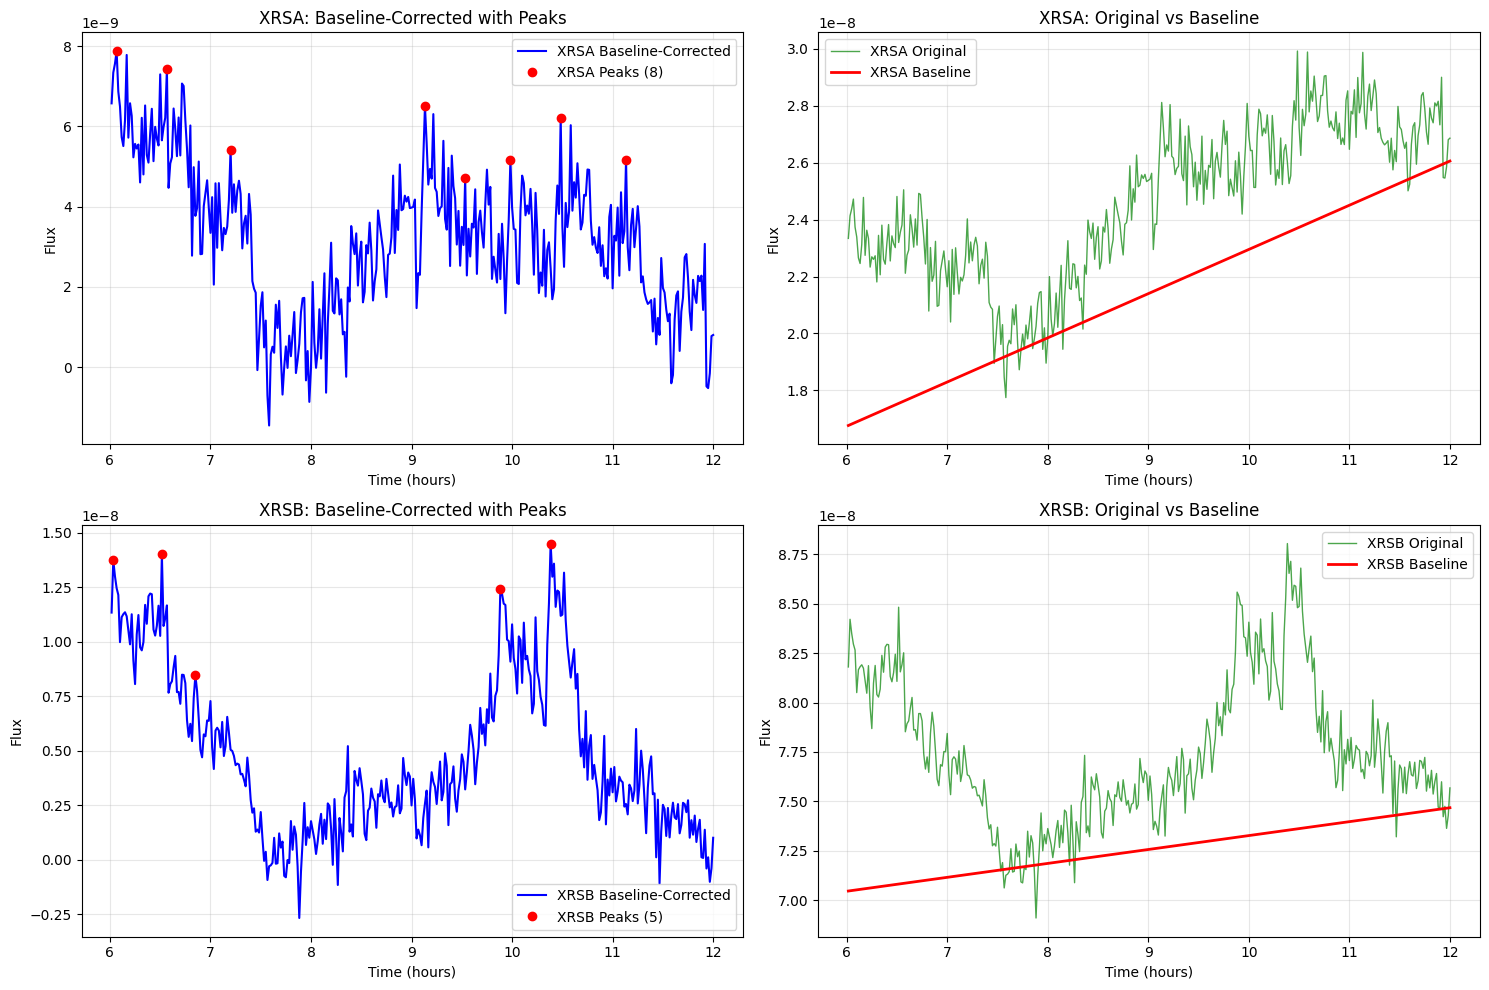

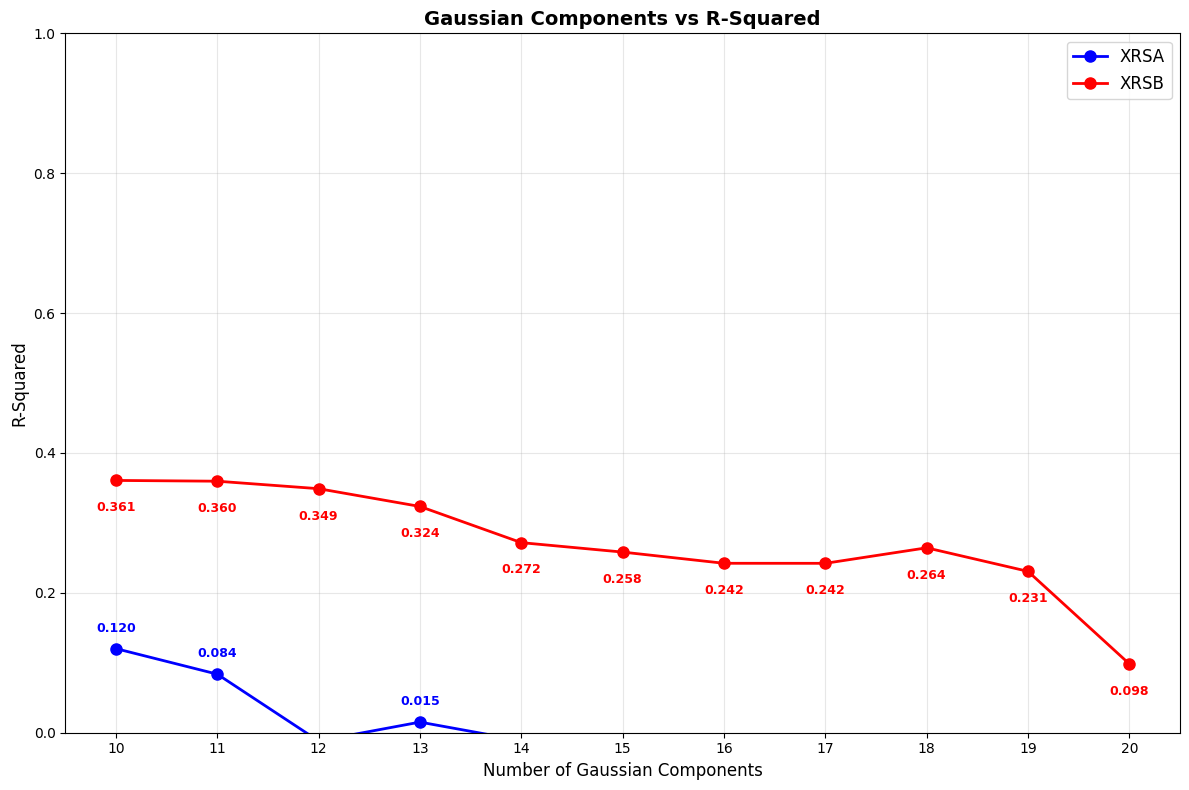


�� Optimal components - XRSA: 10, XRSB: 10


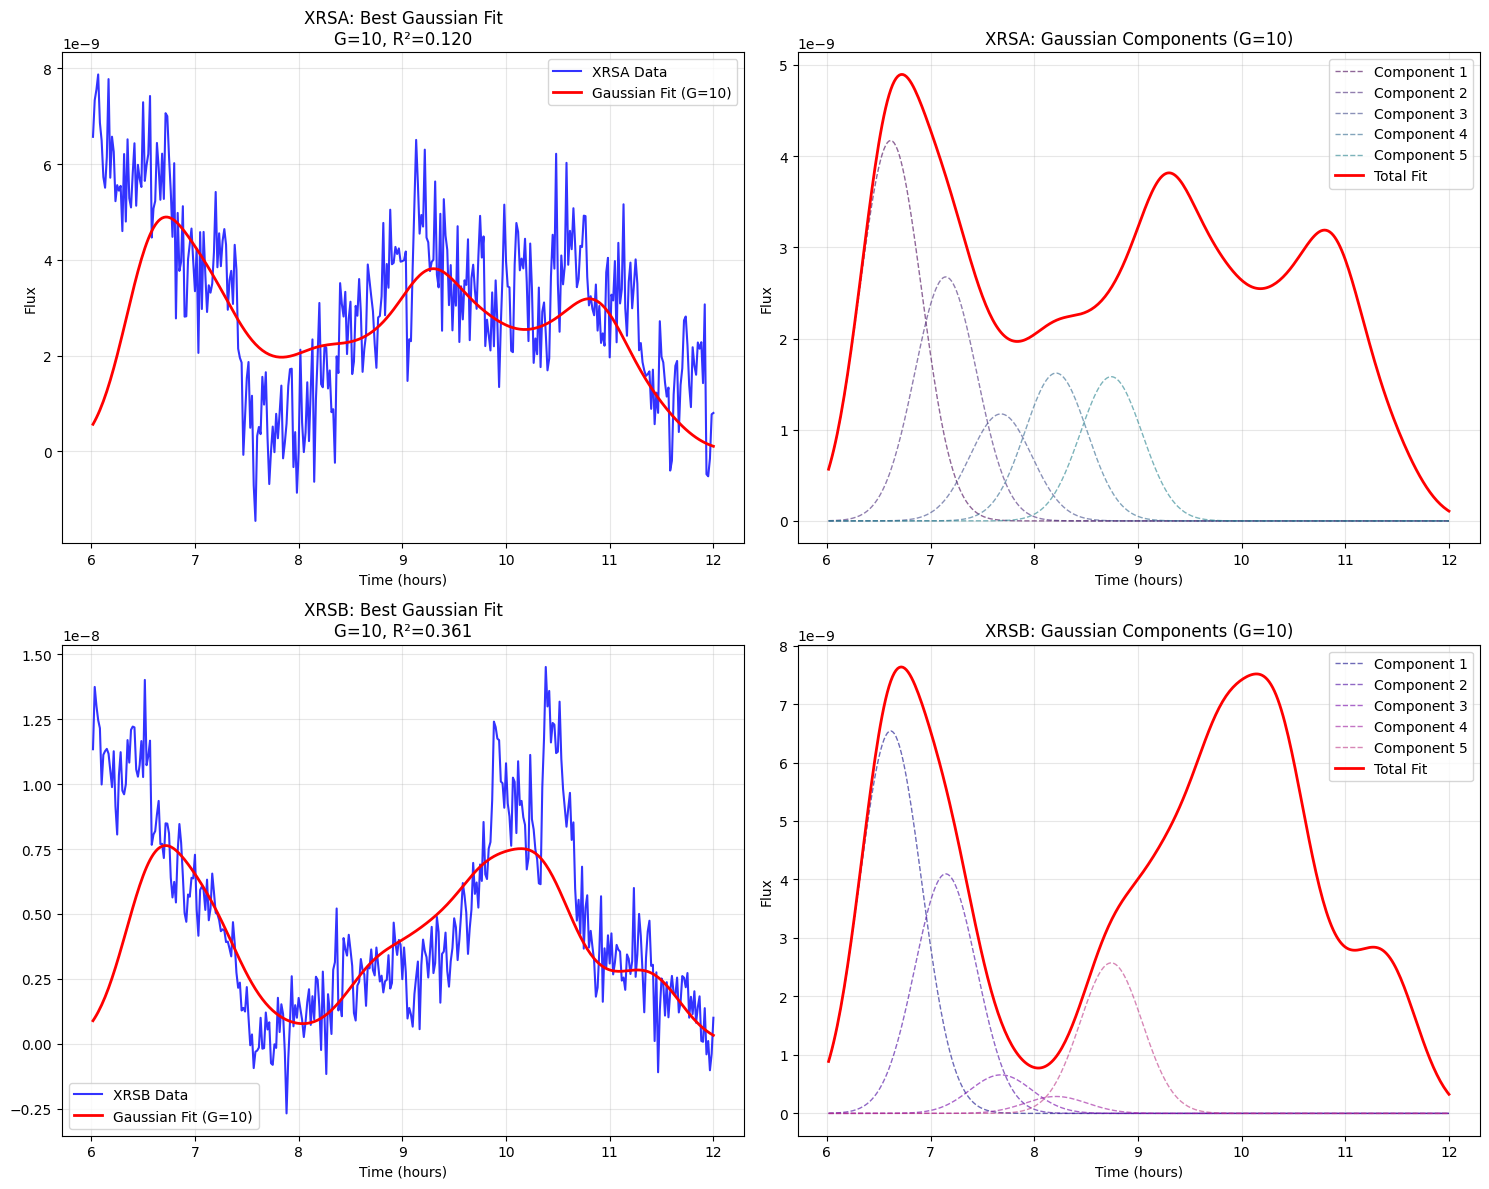


✅ All visualizations completed!


In [37]:
# Run the complete analysis
print("🚀 Starting analysis...")
results = run_analysis(DATA_FILE, START_TIME, END_TIME, MIN_GAUSSIANS, MAX_GAUSSIANS)

if results is None:
    print("❌ Analysis failed. Exiting.")
else:
    results_dict, time_data, xrsa_data, xrsb_data, xrsa_peaks, xrsb_peaks = results
    
    # Load original data for baseline plotting
    data = load_data(DATA_FILE)
    time_minutes = data['time_minutes'].values
    xrsa_original = data['xrsa_flux_observed'].values
    xrsb_original = data['xrsb_flux_observed'].values
    
    # Apply baseline correction for plotting
    use_pybaselines = check_dependencies()
    xrsa_baseline, _, xrsb_baseline, _ = apply_baseline_correction(
        time_data, xrsa_original[START_TIME:END_TIME+1], xrsb_original[START_TIME:END_TIME+1], use_pybaselines
    )
    
    print("\n📊 Generating visualizations...")
    
    # Generate all three plots sequentially
    plot_baseline_correction(time_data, xrsa_original[START_TIME:END_TIME+1], xrsa_baseline, xrsa_data,
                           xrsb_original[START_TIME:END_TIME+1], xrsb_baseline, xrsb_data,
                           xrsa_peaks, xrsb_peaks)
    
    gaussian_range = range(MIN_GAUSSIANS, MAX_GAUSSIANS + 1)
    plot_r2_analysis(gaussian_range, results_dict)
    plot_best_fits(time_data, xrsa_data, xrsb_data, results_dict, gaussian_range)
    
    print("\n✅ All visualizations completed!")